In [3]:
import itertools
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import pickle
import random
from sklearn.model_selection import train_test_split
import time
from joblib import Parallel, delayed
import pandas as pd
import sys
import os
import seaborn as sns 
from sklearn.metrics import r2_score
import math
import matplotlib as mpl
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances
import scipy

# ======
current = os.path.dirname(os.path.realpath('plotting.py'))
parent = os.path.dirname(current)
sys.path.append(parent)
from functions.rnn_cryptic_equals import convert_seq2inputs, calculate_output, onehot2seq 

In [27]:
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)
        self.initialize_weights()
        
    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight, 0.001)
                
def generate_trials(op, input_ids, init_values):
    
    ''' function for generating all permutations of 1 step trials '''
    
    seq = []
    combi_inputcue = list(itertools.product(input_ids, repeat=1))
    for init in init_values:
        for cue in combi_inputcue:
            seq.append([init,
                        *zip(tuple(op), cue), '=']) #group per time point t
    for s in seq:
        s.append(calculate_output(s, cue_dict))
    return seq

def generate_primitives(inputs):
    seq = []
    for inp in inputs:
        trial = [inp, '=']
        trial.append(calculate_output(trial, cue_dict))
        seq.append(trial)
    return seq


def generate_trials(op, input_ids, init_values):
    
    ''' function for generating all permutations of 1 step trials '''
    
    seq = []
    combi_inputcue = list(itertools.product(input_ids, repeat=1))
    for init in init_values:
        for cue in combi_inputcue:
            seq.append([init,
                        *zip(tuple(op), cue), '=']) #group per time point t
    for s in seq:
        s.append(calculate_output(s, cue_dict))
    return seq

def generate_self(op, inputs):
    seq = []
    for inp in inputs:
        trial = generate_trials(op, inp, inp)
        seq += trial
    return seq

def generate_other(op, inputs):
    seq = []
    inputs1 = inputs.copy()
    inputs2 = inputs.copy()
    inputs2.append(inputs2.pop(0))
    for i in range(len(inputs1)):
        trial = [inputs1[i], (op, inputs2[i]), '=']
        trial.append(calculate_output(trial, cue_dict))
        seq.append(trial)
    return seq

def generate_other(op, inputs):
    seq = []
    inputs1 = inputs.copy()
    inputs2 = inputs.copy()
    inputs2.append(inputs2.pop(0))
    for i in range(len(inputs1)):
        trial = [inputs1[i], (op, inputs2[i]), '=']
        trial.append(calculate_output(trial, cue_dict))
        seq.append(trial)
    return seq

def generate_other_reverse(op, inputs):
    seq = []
    inputs1 = inputs.copy()
    inputs2 = inputs.copy()
    inputs2.append(inputs2.pop(0))
    inputs2.append(inputs2.pop(0))
    for i in range(len(inputs1)):
        trial = [inputs1[i], (op, inputs2[i]), '=']
        trial.append(calculate_output(trial, cue_dict))
        seq.append(trial)
    return seq

def generate_other_reverse_primitives(op, inputs):
    seq = []
    inputs1 = inputs.copy()
    inputs2 = inputs.copy()
    n = int(len(inputs1)/2)
    for i in range(n):
        trial = [inputs1[i], (op, inputs2[i+n]), '=']
        trial.append(calculate_output(trial, cue_dict))
        seq.append(trial)
    return seq

def change_dict(seqs, new_dict):
    """ recalculates sequence output"""
    inps = [s[:-1] for s in seqs]
    for inp in inps:
        inp.append(calculate_output(inp, new_dict))

    return inps


## running function
def get_reps(model, testdata, hidden_size):
    model.eval()
    trials = []
    hiddens = []
    for testset in testdata:
        for x,y in testset:
            for i in range(len(x)):
                hidden_arr = np.empty((0,  hidden_size))
                hidden = torch.zeros(1, hidden_size)[0]
                for step in x[i]:
                    hidden, y_hat = model.get_activations(step,hidden)
                    hidden_arr = np.vstack([hidden_arr, hidden.detach().numpy()])
            hiddens.append(hidden_arr)
            trials.append(str(onehot2seq(x)))

    return hiddens, trials 



In [28]:
save_dir = '../results/representation_analysis/other/'

with open(save_dir+'res_other', 'rb') as f:
    res1 = pickle.load(f)

In [29]:
ops = '+'

num_inputs = 4
total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
all_syms = total_syms[:num_inputs]
all_input_vals = list(np.arange(2,18))
input_vals = random.sample(all_input_vals,num_inputs)
input_vals.sort()
# randomly select values for each input
cue_dict = {}
for i, s in enumerate(all_syms):
    cue_dict[s] = input_vals[i]
    
print(cue_dict)
primitives = generate_primitives(all_syms)
rp = generate_other_reverse_primitives('+', all_syms)
print(primitives)
print(rp)

{'A': 9, 'B': 13, 'C': 14, 'D': 16}
[['A', '=', 9], ['B', '=', 13], ['C', '=', 14], ['D', '=', 16]]
[['A', ('+', 'C'), '=', 23], ['B', ('+', 'D'), '=', 29]]


In [30]:
# data
num_classes = 22
batchsize=1

# RNN specs
input_size = num_classes
output_size = 1
num_layers = 1
hidden_size = 20
learningRate = 0.005

## running params
epochs = 1200
num_sims = 104

In [34]:
## calculate distance matrices for all models and steps 

## find indices of 100% acc rnns
acc_df = res1['acc_df']
all_acc_mods = acc_df[(acc_df['acc_train'] == 1) & (acc_df['acc_train_p'] == 1)].index
print('no. 100% trained RNNs: ', len(all_acc_mods))

mod_list = all_acc_mods
# mod_list = np.arange(num_sims)

# initialise empty lists/arrays
avg_dists = np.empty((len(mod_list),4))
avg_dists_p = np.empty((len(mod_list),4))
dms = [[] for _ in range(4)]
dms_p = [[] for _ in range(4)]

# extracts results from dictionary
mods = res1['mods']
mods_p = res1['mods_p']
cue_dicts = res1['cue_dicts']
testseq = generate_trials(ops, all_syms, all_syms)
ft_cue_dicts = [cue_dicts[j] for j in mod_list]

for ind, m in enumerate(mod_list): # for each model 
# for m in all_acc_mods:
    testseqs = change_dict(testseq, cue_dicts[m])
    train_inputs = convert_seq2inputs(testseq, num_classes=num_classes, seq_len=5)
    testset = DataLoader(train_inputs, batch_size=batchsize, shuffle=False)
    # get activations for control model
    hiddens, trials = get_reps(mods[m], [testset], hidden_size)
    for h in range(4): 
        hid_val = np.array([hid[h,:] for hid in hiddens]) # combine activations from each context for the time step
        dm = euclidean_distances(hid_val) # calculate euclidean distance between contexts
        dms[h].append(dm)
        av = scipy.sparse.triu(dm).mean() # find mean distance between contexts from upper triangular matrix
        avg_dists[ind, h] = av
    # get activations for primitive trained model
    hiddens_p, trials = get_reps(mods_p[m], [testset], hidden_size)    
    for h in range(4):
        hid_val = np.array([hid[h,:] for hid in hiddens_p])
        dm = euclidean_distances(hid_val)
        dms_p[h].append(dm)
        av = scipy.sparse.triu(dm).mean()
        avg_dists_p[ind, h] = av


no. 100% trained RNNs:  526


# Regression

In [35]:
from sklearn.linear_model import LinearRegression

In [38]:
def regress_RDM_abs(s, dms):
    rs = []
    for i, cd in enumerate(ft_cue_dicts):
        curr_tests = change_dict(testseqs, ft_cue_dicts[i])
        truth_outs = [t[-1] for t in curr_tests]
        truth_RDM = abs(np.array([truth_outs]*16) - np.array([truth_outs]*16).T)
        x = dms[s][i].reshape(-1,1)
        y = truth_RDM.reshape(16*16)
        model = LinearRegression().fit(x, y)
        r_sq = model.score(x, y)
        rs.append(r_sq)
    return rs


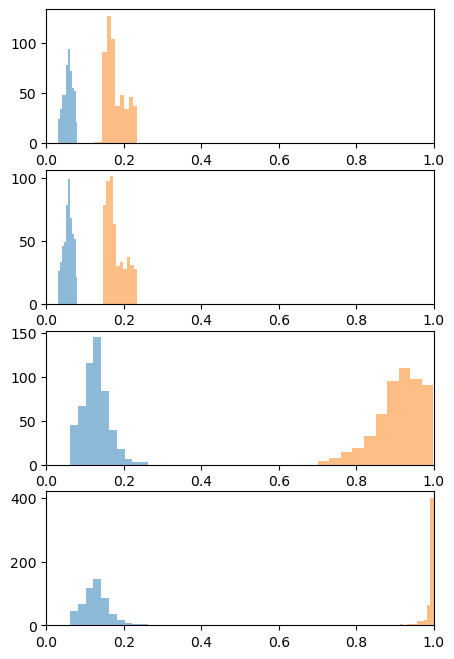

In [44]:
plt.rcParams["figure.figsize"] = (5,8)
fig, ax = plt.subplots(4,1)
for s in range(4): 
    rs = regress_RDM_abs(s, dms)
    rs_p = regress_RDM_abs(s, dms_p)
    ax[s].hist(rs, alpha=0.5)
    ax[s].hist(rs_p, alpha=0.5)
    ax[s].set_xlim(0,1)

In [37]:
scipy.stats.wilcoxon(rs, rs_p, zero_method = 'wilcox')

WilcoxonResult(statistic=0.0, pvalue=7.189158318658634e-88)